# Preprocessing text data for NLP analysis
## Author: Karina Lopez
### Last updated: 04/20/2021

**Purpose:** Clean raw text data for NLP analysis. Steps include tokenization, lower-casing, stop-word removal, stemming, and lemmatization

Sources: 
- [Towards data science](https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8)
- [KD Nuggets](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html#:~:text=Expanding%20Contractions&text=These%20shortened%20versions%20or%20contractions,I%20would%20to%20I'd.)
- [digital ocean](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)



# Load in your packages and default styles

In [1]:
import spacy
import pandas as pd
import glob
import os

import seaborn as sns
sns.set_style('darkgrid')

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
nltk.download('punkt')

from wordcloud import WordCloud


import re, string, random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

#setting pandas display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

BASE_DIR = "/Users/karinalopez/Desktop/ds_projects/nlp/data/"

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/karinalopez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-1-7410d48c54c7>:30: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # or 199


## Functions + Helper variables

In [2]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [3]:
# removes keywords from your text data

def map_keyword(df, kw, kw_list, col = 'title', col_name = 'title_preprocessed'):
    
    # filter to only replace keyword data
    temp = df.loc[df['keyword'] == kw]
    
    # replace keyword in string column
    temp[col_name] = temp[col].str.replace('|'.join(kw_list), 'keyword') 
    
    return(temp)
    
    

In [4]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        
        expanded_contraction = first_char + expanded_contraction[1:]
        
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    
    return expanded_text


In [5]:
def remove_stopwords(tokens, is_lower_case = True):
    
    #tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    
    return filtered_text



In [6]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    
    # Set figure size
    plt.figure(figsize = (40, 30))
    
    # Display image
    plt.imshow(wordcloud) 
    
    # No axis details
    plt.axis("off");

# Load in your files

In [7]:
os.chdir(BASE_DIR + 'raw/ffa/')
posts_df = pd.read_csv('MEGA_ffa_posts_company.csv')
comments_df = pd.read_csv('MEGA_ffa_comments_company.csv')

In [8]:
print(posts_df.shape)
posts_df.head(n = 1)

(247, 8)


,title,score,id,url,comms_num,created,body,keyword
0,"A review of all the leggings I own - Alo Yoga, Nike, Outdoor Voices, Girlfriend Collective, Lululemon, Uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective


In [9]:
posts_df['keyword'].value_counts()

Nike                     100
Lululemon                52 
Adidas                   47 
Athleta                  37 
Girlfriend Collective    9  
Alo Yoga                 2  
Name: keyword, dtype: int64

In [10]:
print(comments_df.shape)
comments_df.head(n = 1)

(17960, 5)


,comment_id,comment_parent_id,comment_body,comment_link_id,keyword
0,fp6qtho,t3_gbm76k,"This is amazing! Thank you for putting it together!\n\nHonestly I’ve tried so many brands: GF Collective, Lululemon, Aerie, Nike, Athleta etc and the ones I always come back to are Old Navy. They are so comfortable and wash well and very affordable. \n\nThe Old Navy compression leggings retain their compression even with multiple washes. I also like the yoga leggings which are less compressive but still have a bit of compression. Those are a little softer than the compressive ones but I love both. I tried a bunch of fancier brands and ended up just going back to old navy.",t3_gbm76k,Girlfriend Collective


In [11]:
comments_df['keyword'].value_counts()

Nike                     6626
Lululemon                4014
Adidas                   3406
Athleta                  2906
Alo Yoga                 519 
Girlfriend Collective    489 
Name: keyword, dtype: int64

# Problems solved with this script:
- Lowercasing words X
- Tokenization X
- Stop-word removal X
- Stemming X
- Lemmatization

## Lowercasing

A very simple that facilitates text analysis is lowercasing all string characters in a comment or tecxt body. Excluding this step would cause wird frequencies and other text analyses to interpret words like "USA", "UsA", and "usa" as separate

In [12]:
posts_df['title'] = posts_df['title'].str.lower()

In [13]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective


## Mapping keywords

In [14]:
gf_wrds = ['gf collective', 'girlfriend collective']
gf_df = map_keyword(posts_df, 'Girlfriend Collective', gf_wrds)

nike_df = map_keyword(posts_df, 'Nike', ['nike'])

lululemon_df = map_keyword(posts_df, 'Lululemon', ['lululemon'])

adidas_df = map_keyword(posts_df, 'Adidas', ['adidas'])

athleta_df = map_keyword(posts_df, 'Athleta', ['athleta'])

ay_df = map_keyword(posts_df, 'Alo Yoga', ['alo yoga'])


<ipython-input-3-dd8205bf39da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[col_name] = temp[col].str.replace('|'.join(kw_list), 'keyword')


In [15]:
# add them all back to a new dataframe
posts_df = pd.concat([gf_df, nike_df, lululemon_df, adidas_df, athleta_df, ay_df])

In [16]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,"a review of all the leggings i own - alo yoga, nike, outdoor voices, keyword, lululemon, uniqlo"
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,"the economics view on sweatshops, objections, and consumer action"


## Expand contractions

In [17]:
posts_df['title_preprocessed'] = posts_df['title_preprocessed'].apply(expand_contractions)


In [18]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,"a review of all the leggings i own - alo yoga, nike, outdoor voices, keyword, lululemon, uniqlo"
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,"the economics view on sweatshops, objections, and consumer action"


## Removing punctuation and noise

In [19]:
# remove unnecessary punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
posts_df['title_preprocessed'] = posts_df['title_preprocessed'].apply(tokenizer.tokenize)

In [20]:
# add them back into a long string
posts_df['title_preprocessed']= posts_df['title_preprocessed'].str.join(" ")

In [21]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,a review of all the leggings i own alo yoga nike outdoor voices keyword lululemon uniqlo
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,the economics view on sweatshops objections and consumer action


## Tokenization
Splitting sentences into words

In [22]:
posts_df['tokenized'] = posts_df['title_preprocessed'].apply(word_tokenize)



In [23]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed,tokenized
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,a review of all the leggings i own alo yoga nike outdoor voices keyword lululemon uniqlo,"[a, review, of, all, the, leggings, i, own, alo, yoga, nike, outdoor, voices, keyword, lululemon, uniqlo]"
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,the economics view on sweatshops objections and consumer action,"[the, economics, view, on, sweatshops, objections, and, consumer, action]"


## Stop-word removal

In [24]:
# Grab your stop word list from NLTK
os.chdir('/Users/karinalopez/Desktop/ds_projects/nlp/nltk_data/corpora/stopwords')
stopword_list = stopwords.words('english')

In [25]:
posts_df['title_preprocessed'] = posts_df['tokenized'].apply(remove_stopwords)



In [26]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed,tokenized
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,review leggings alo yoga nike outdoor voices keyword lululemon uniqlo,"[a, review, of, all, the, leggings, i, own, alo, yoga, nike, outdoor, voices, keyword, lululemon, uniqlo]"
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,economics view sweatshops objections consumer action,"[the, economics, view, on, sweatshops, objections, and, consumer, action]"


## Stemming

In [27]:
posts_df['tokenized'].iloc[0]

['a',
 'review',
 'of',
 'all',
 'the',
 'leggings',
 'i',
 'own',
 'alo',
 'yoga',
 'nike',
 'outdoor',
 'voices',
 'keyword',
 'lululemon',
 'uniqlo']

In [28]:
# should add a boolean so that words that are company names are not stemmed
do_not_stem = ['alo yoga', 'athleta', 'adidas', 'lululemon', 'nike', 'keyword']

In [29]:
def simple_stemmer(text):
    
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    
    return text


In [30]:
posts_df['stemmed'] = posts_df['title_preprocessed'].apply(simple_stemmer)



In [31]:
posts_df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed,tokenized,stemmed
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,review leggings alo yoga nike outdoor voices keyword lululemon uniqlo,"[a, review, of, all, the, leggings, i, own, alo, yoga, nike, outdoor, voices, keyword, lululemon, uniqlo]",review leg alo yoga nike outdoor voic keyword lululemon uniqlo
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,economics view sweatshops objections consumer action,"[the, economics, view, on, sweatshops, objections, and, consumer, action]",econom view sweatshop object consum action


## Lemetization

def lemmatize_text(text):
    
    text = nlp(text)
    
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")


## create a wordcloud for all posts associated by each company

In [32]:
#os.chdir(BASE_DIR + 'intermediate/')
#posts_df.to_csv('posts_preprocessed.csv', index = False)

In [33]:
os.chdir(BASE_DIR + 'intermediate/')
df = pd.read_csv('posts_preprocessed.csv')

In [34]:
df.head(n = 2)

,title,score,id,url,comms_num,created,body,keyword,title_preprocessed,tokenized,stemmed
0,"a review of all the leggings i own - alo yoga, nike, outdoor voices, girlfriend collective, lululemon, uniqlo",1546,gbm76k,https://www.reddit.com/r/femalefashionadvice/comments/gbm76k/a_review_of_all_the_leggings_i_own_alo_yoga_nike/,355,1588353444,t3_gbm76k,Girlfriend Collective,review leggings alo yoga nike outdoor voices keyword lululemon uniqlo,"['a', 'review', 'of', 'all', 'the', 'leggings', 'i', 'own', 'alo', 'yoga', 'nike', 'outdoor', 'voices', 'keyword', 'lululemon', 'uniqlo']",review leg alo yoga nike outdoor voic keyword lululemon uniqlo
1,"the economics view on sweatshops, objections, and consumer action",51,8kfhsa,https://www.reddit.com/r/femalefashionadvice/comments/8kfhsa/the_economics_view_on_sweatshops_objections_and/,11,1526668983,t3_8kfhsa,Girlfriend Collective,economics view sweatshops objections consumer action,"['the', 'economics', 'view', 'on', 'sweatshops', 'objections', 'and', 'consumer', 'action']",econom view sweatshop object consum action


In [35]:
gfc_df = df.loc[df['keyword'] == 'Girlfriend Collective']
nike_df = df.loc[df['keyword'] == 'Nike']
adidas_df = df.loc[df['keyword'] == 'Adidas']
lululemon_df = df.loc[df['keyword'] == 'Lululemon']
ay_df = df.loc[df['keyword'] == 'Alo Yoga']
althleta_df = df.loc[df['keyword'] == 'Athleta']


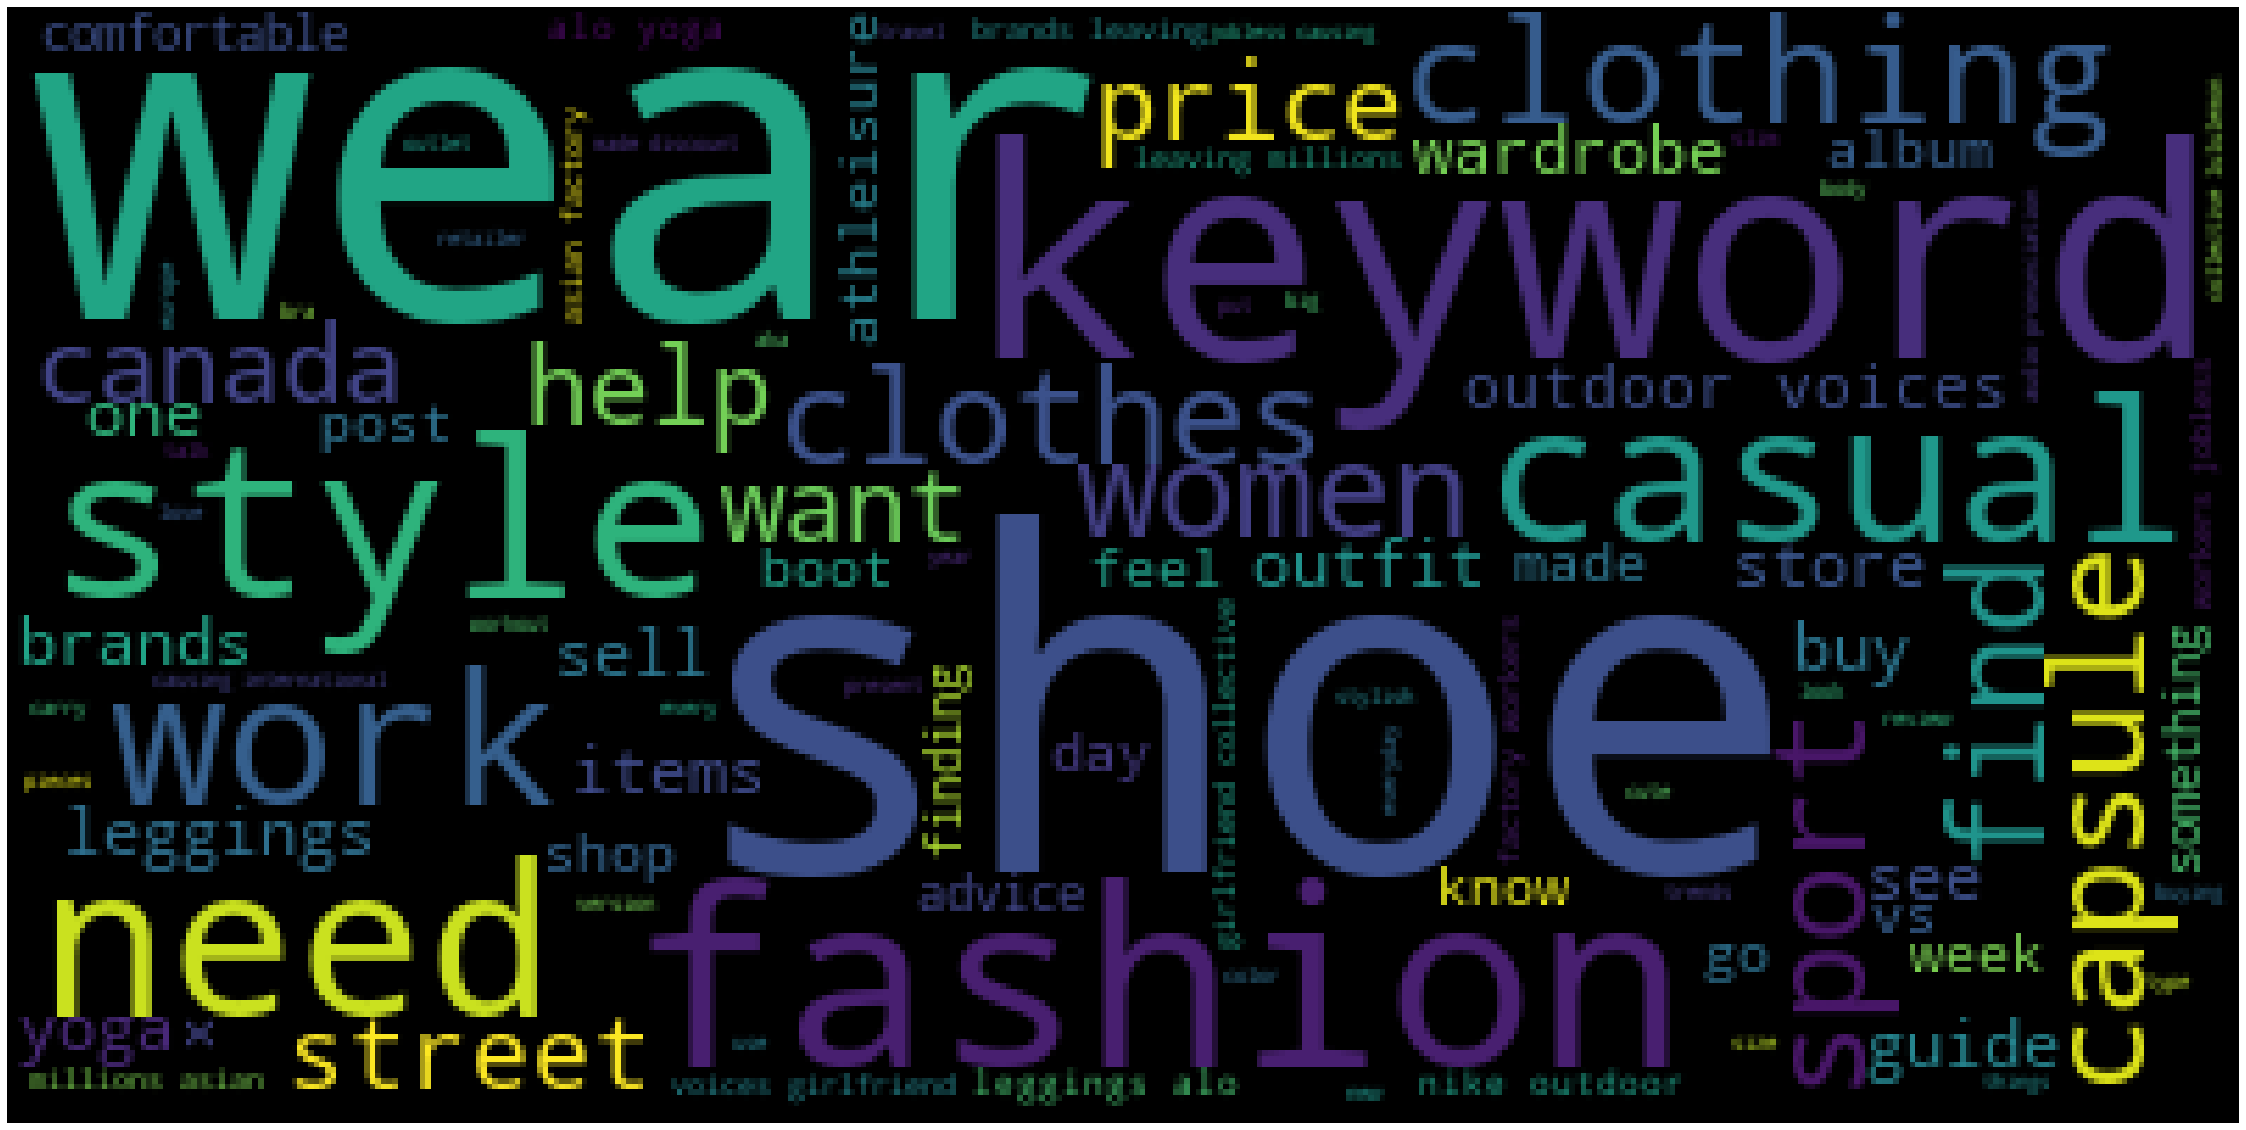

In [36]:
general_wc = WordCloud().generate(''.join(df['title_preprocessed']))
plot_cloud(general_wc)

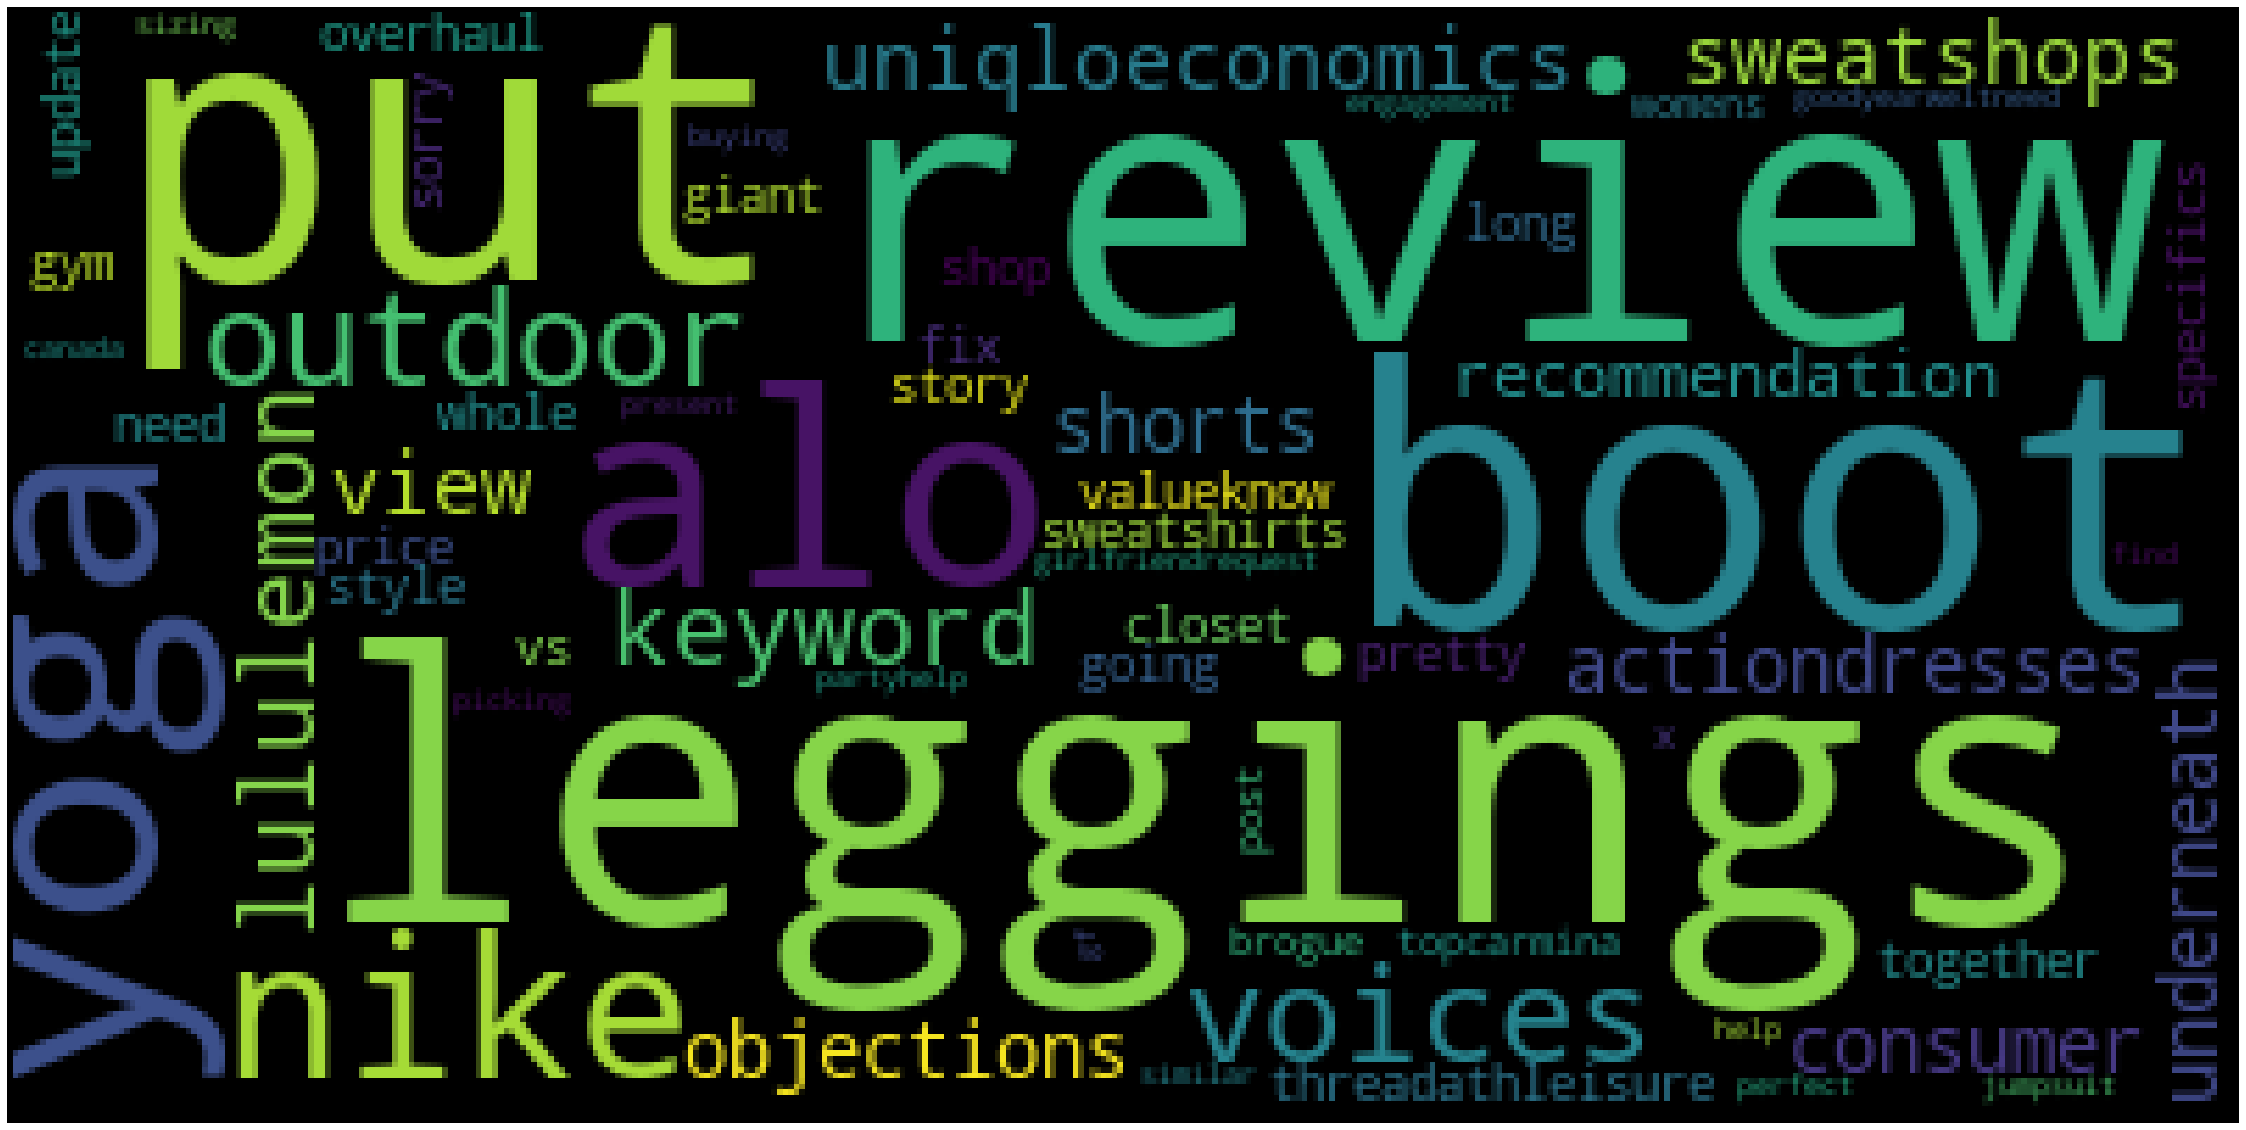

In [37]:
gfc_wc = WordCloud().generate(''.join(gfc_df['title_preprocessed']))
plot_cloud(gfc_wc)

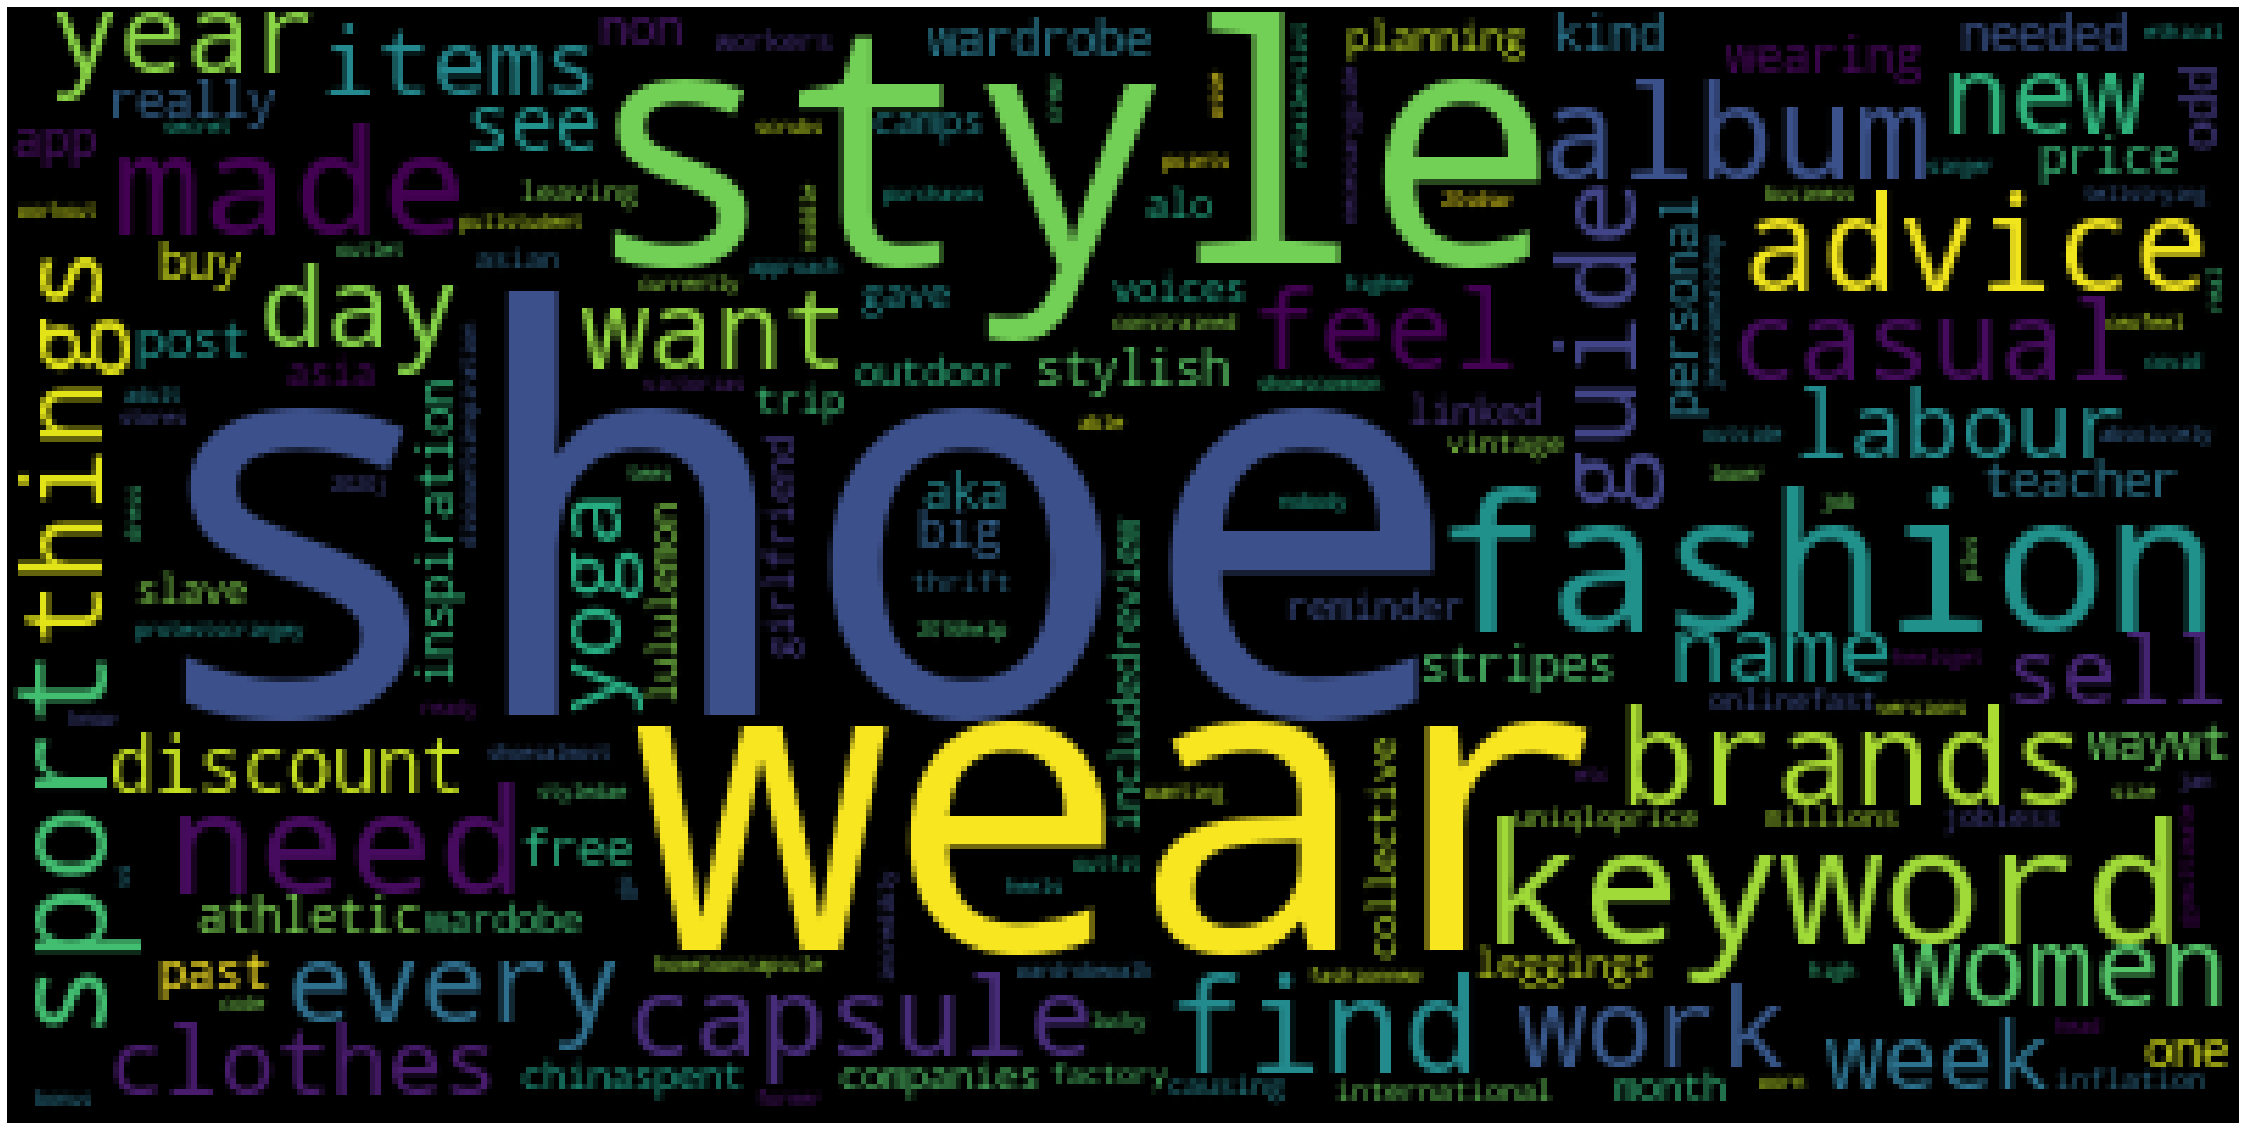

In [38]:
nike_wc = WordCloud().generate(''.join(nike_df['title_preprocessed']))
plot_cloud(nike_wc)

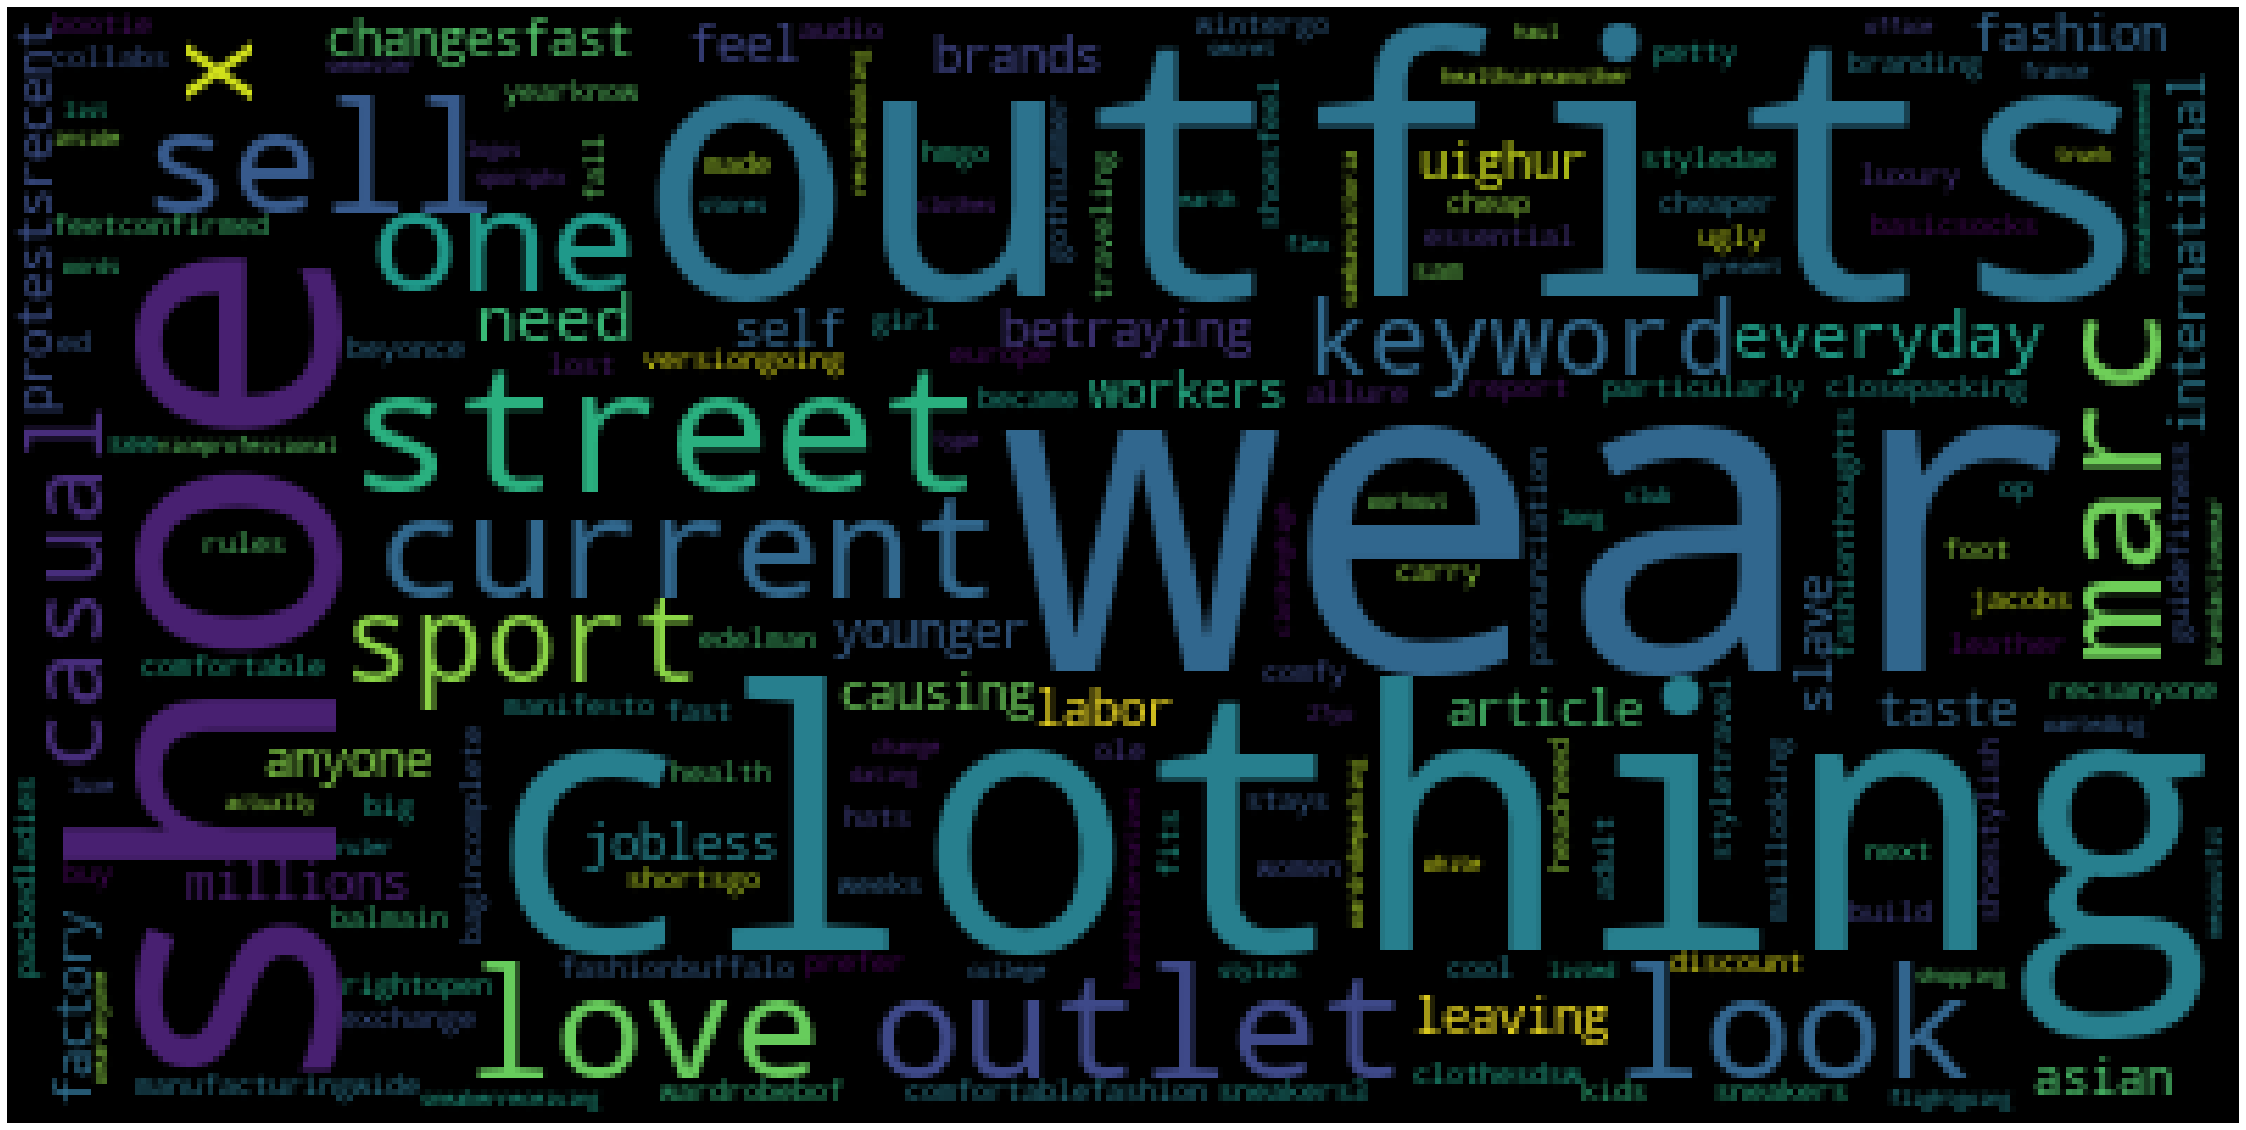

In [39]:
adidas_wc = WordCloud().generate(''.join(adidas_df['title_preprocessed']))
plot_cloud(adidas_wc)

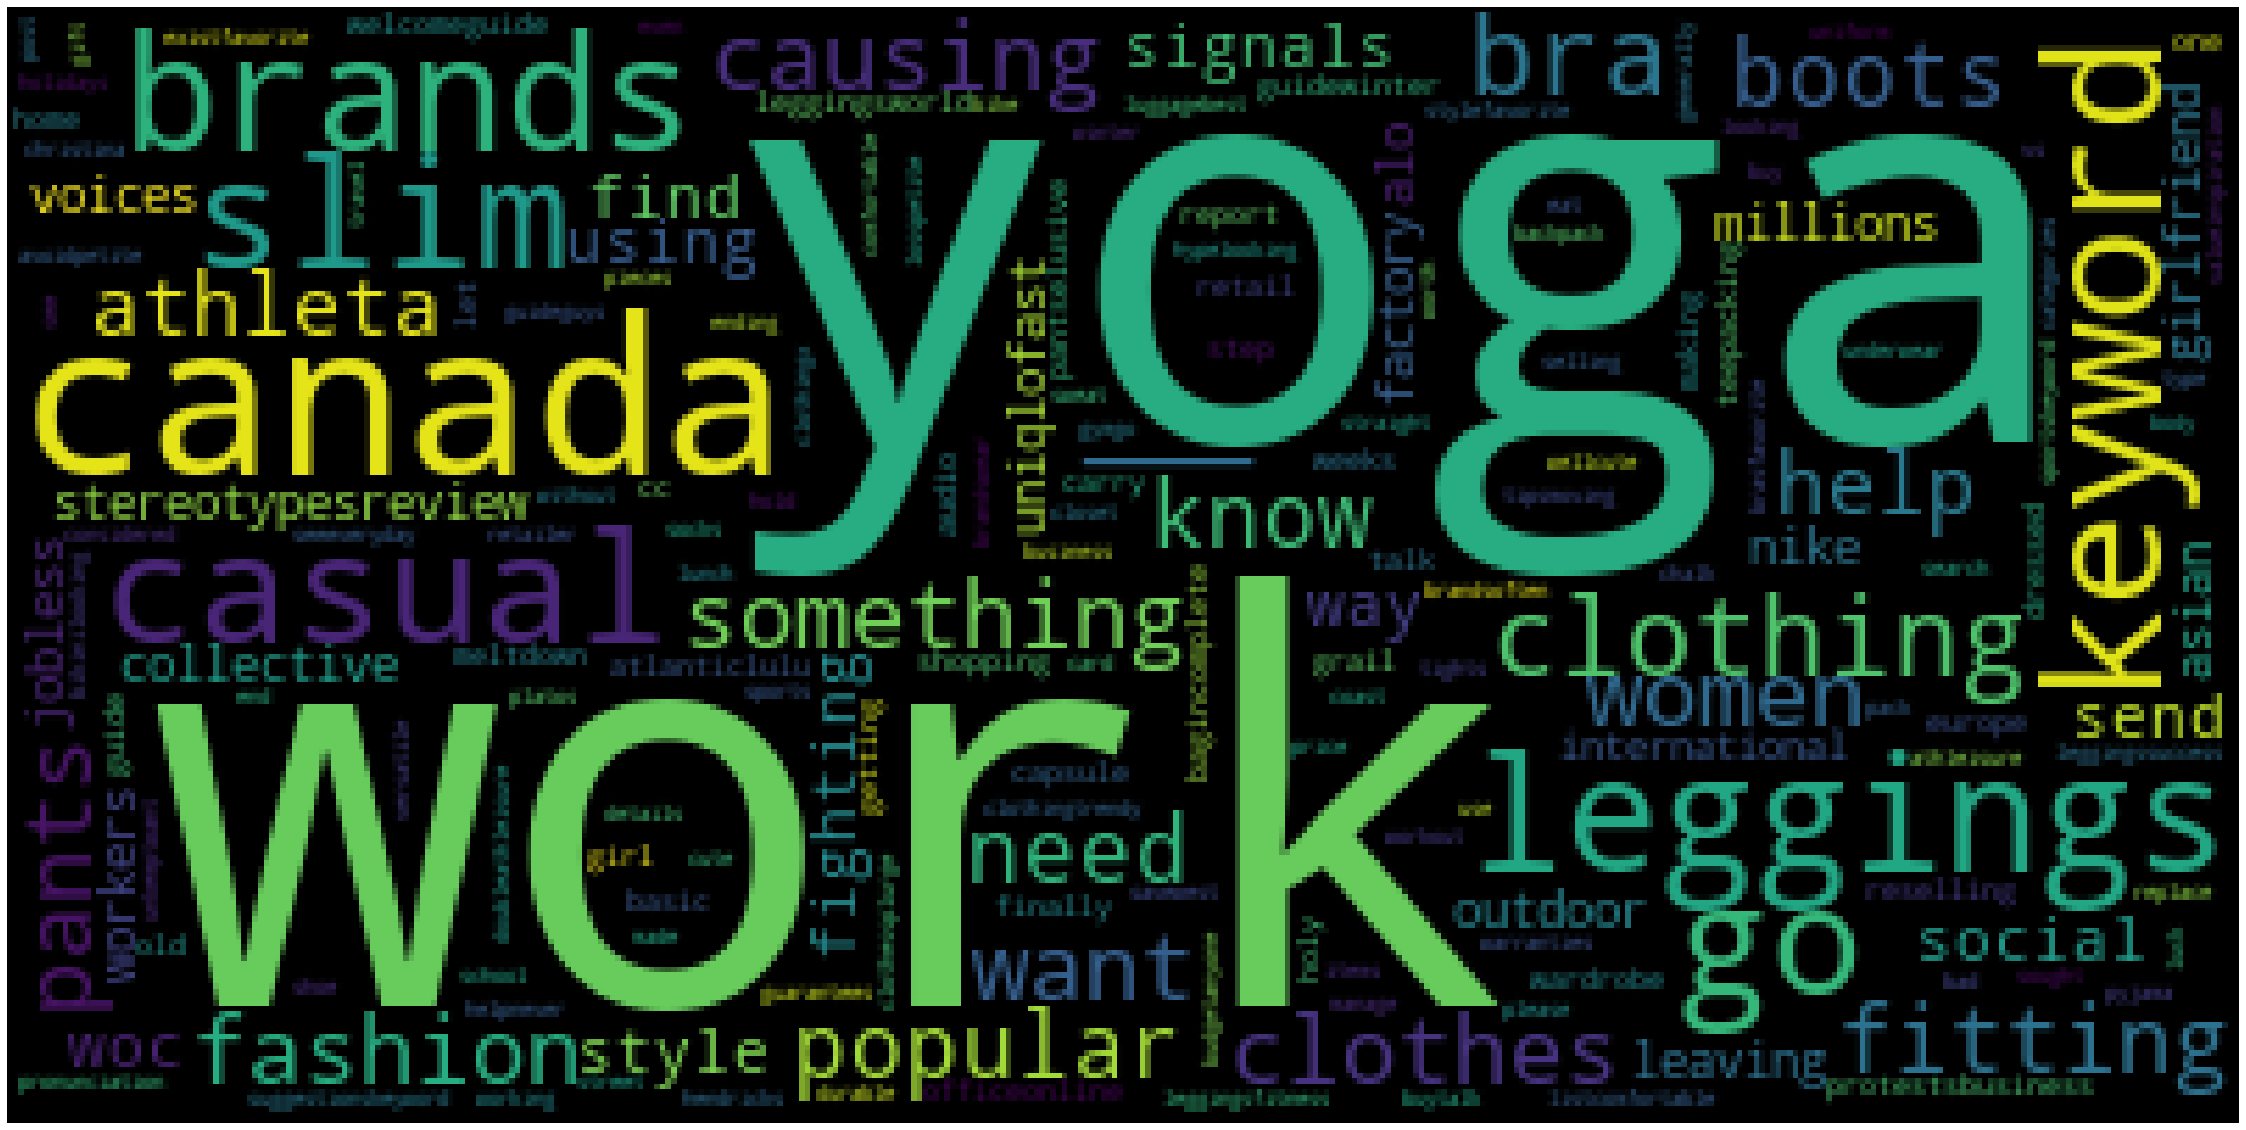

In [40]:
lululemon_wc = WordCloud().generate(''.join(lululemon_df['title_preprocessed']))
plot_cloud(lululemon_wc)

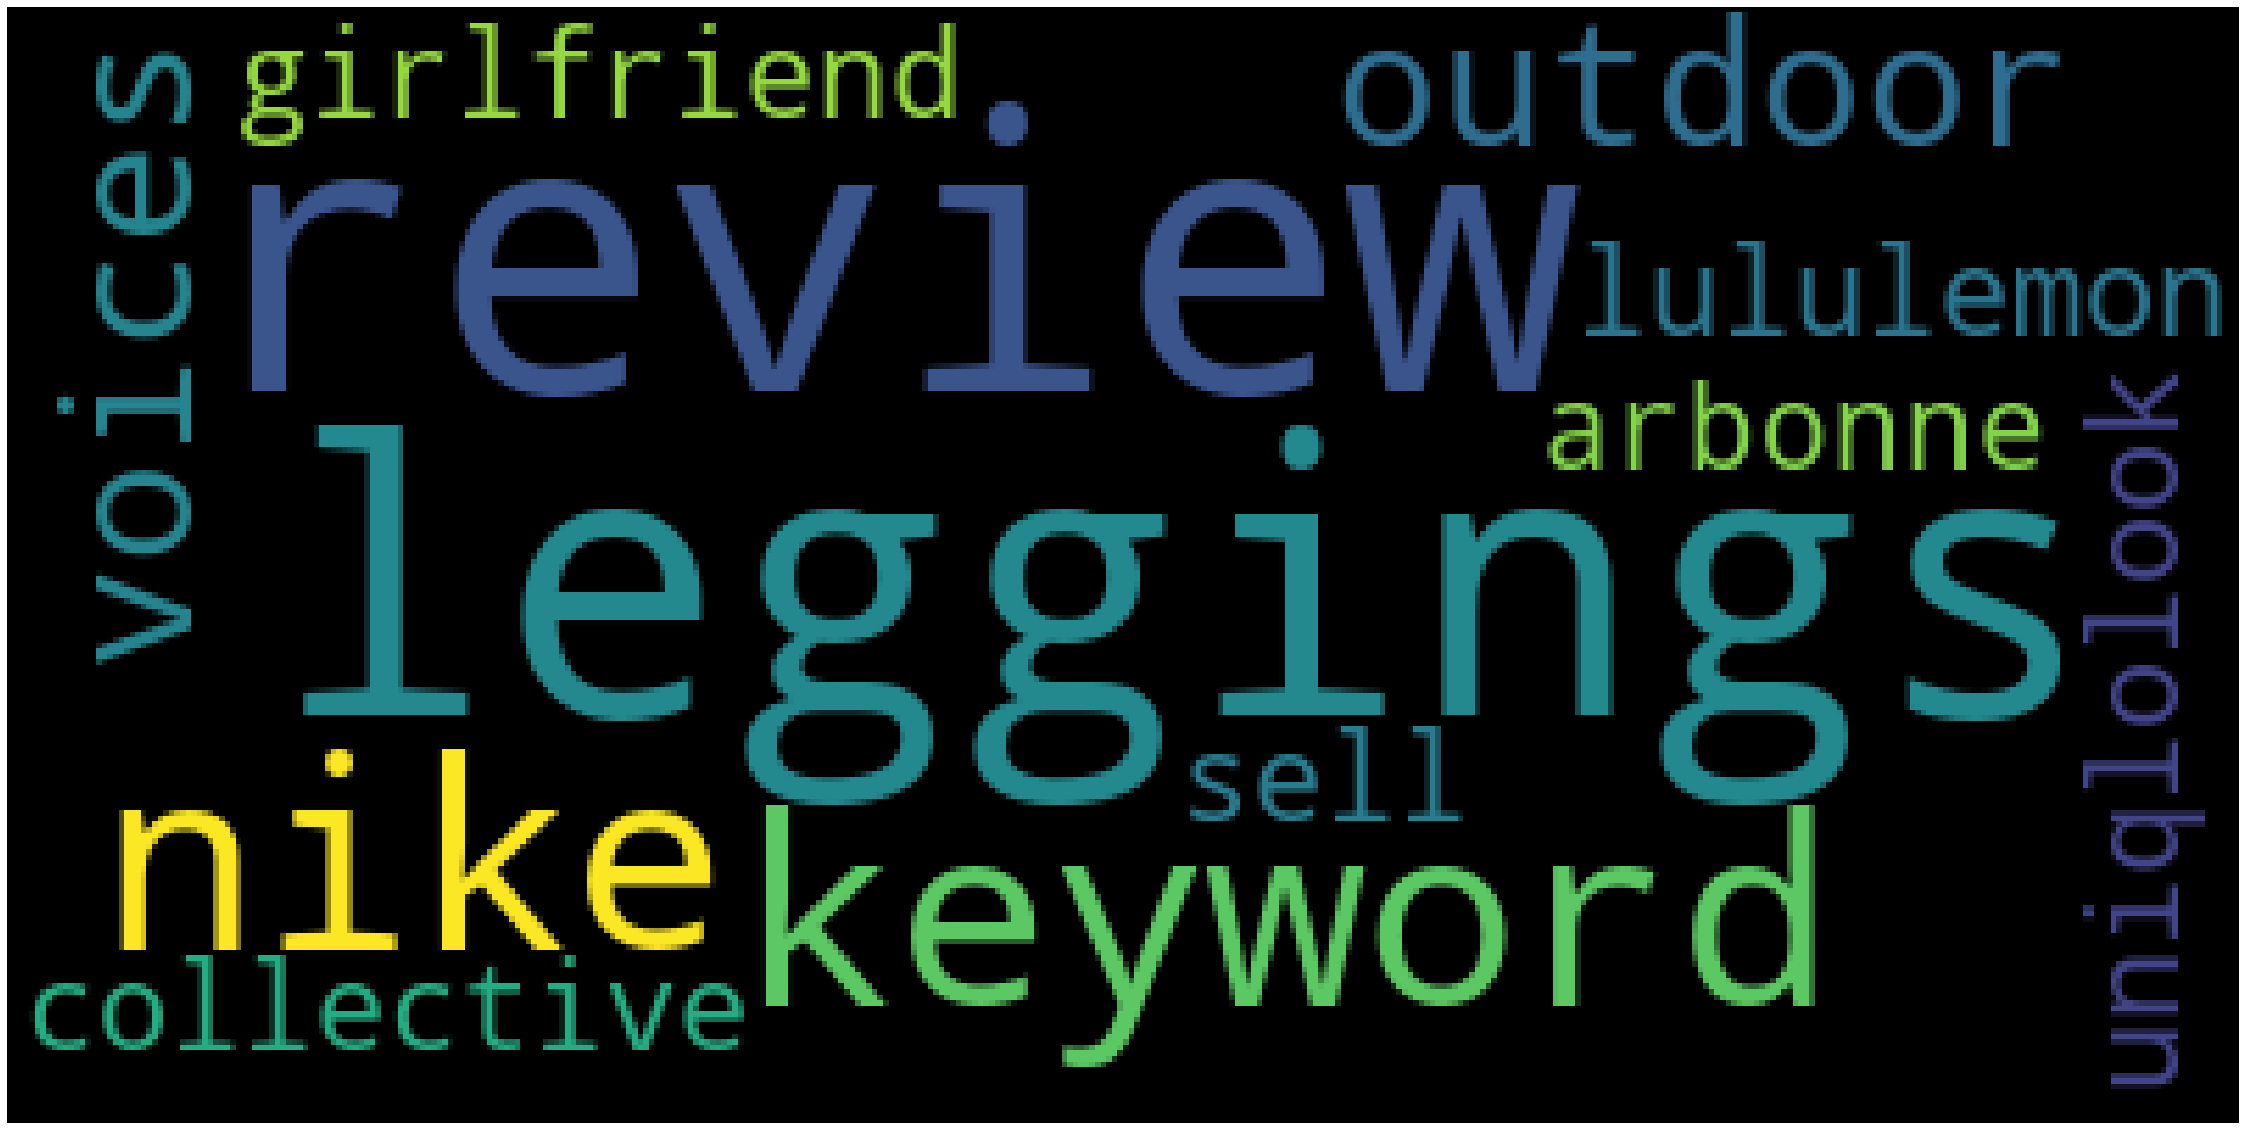

In [41]:
ay_wc = WordCloud().generate(''.join(ay_df['title_preprocessed']))
plot_cloud(ay_wc)

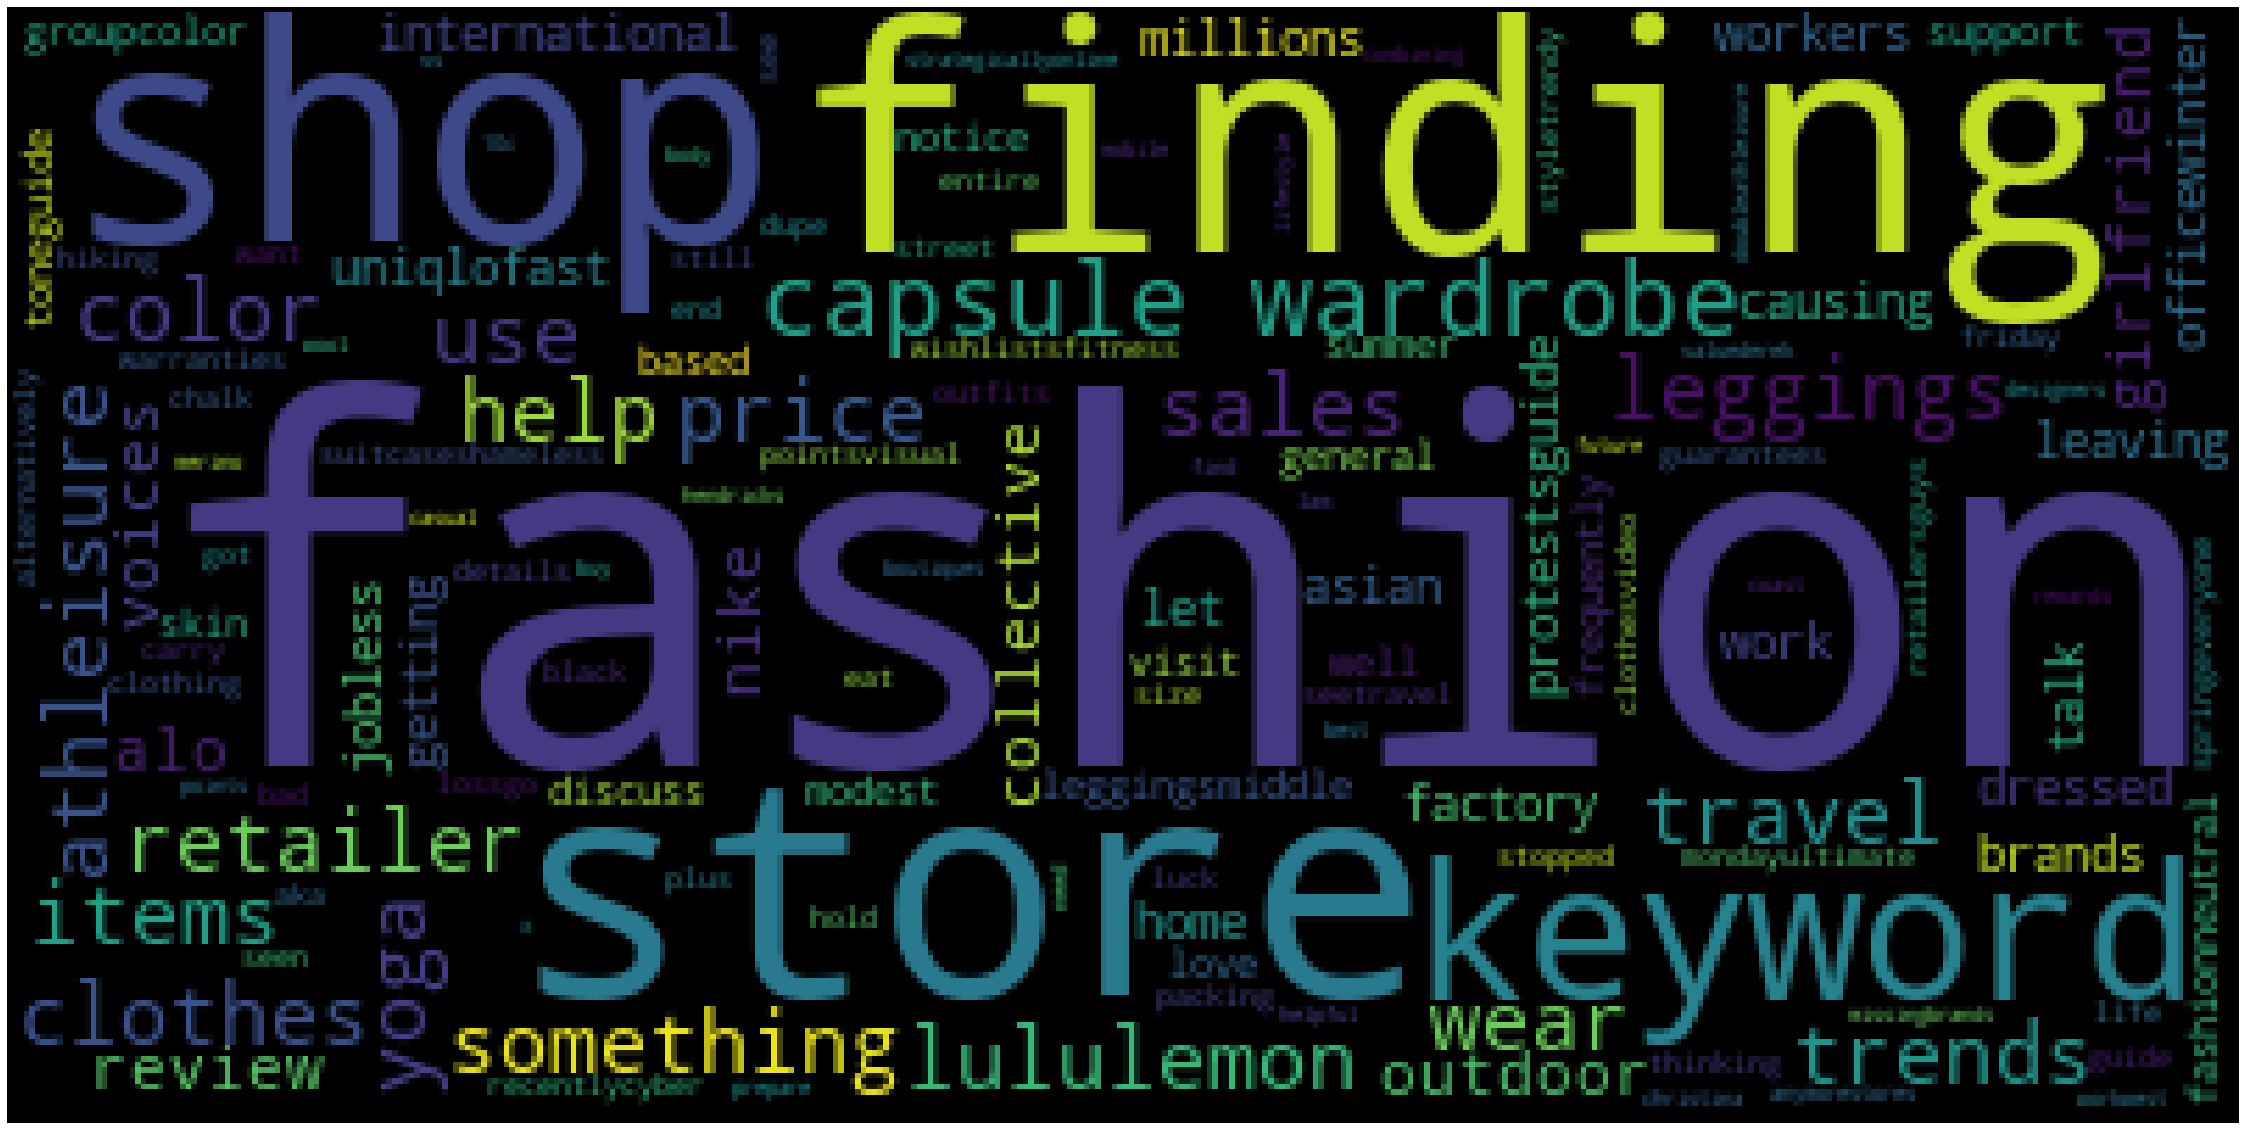

In [42]:
althleta_wc = WordCloud().generate(''.join(althleta_df['title_preprocessed']))
plot_cloud(althleta_wc)